### Siamese GAN

image_size = 32
channels = 1

in plus fata de tot restu modelelor, cateagoria A are pop blues country, nu doar pop.
Categoria B are doar rock.

Am adaugat self.second in discriminator fara gaussian noise, pt ca la feature matching generatorul capata noise ca asa le vede discriminatoru

v2
lrD = 0.000001
feature matching are 2 *
gen converge pe la 2000

v3
lrD = 0.000001
feature matching are 4 *

In [1]:
import pathlib
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from tqdm import tqdm
from PIL import Image
import os
from torch.optim.lr_scheduler import ReduceLROnPlateau
import joblib

In [2]:
ngpu = 0
pathA = "Data/SpectrogramsA"
pathB = "Data/SpectrogramsB"
filename_gen = "TraVeLGAN/noise_feat-matching_gen4layers_20epoci_32x16/TraVeLGAN-Gen.joblib"
filename_dis = "TraVeLGAN/noise_feat-matching_gen4layers_20epoci_32x16/TraVeLGAN-Dis.joblib"
filename_sim = "TraVeLGAN/noise_feat-matching_gen4layers_20epoci_32x16/TraVeLGAN-Siam.joblib"
workers = 2
batch_size = 32

image_size = 32

# channels nr for input images
nc = 1
# size of feature maps in generator
ngf = 64
# size of feature maps in discriminator
ndf = 64
# length of latent vector
lenvec = 128

num_epochs = 20
lr = 0.0002
lrD = 0.000001
beta1 = 0.5

def find_classes(directory:str):
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

    class_to_index = {class_name: i for i, class_name in enumerate(classes)}

    return classes, class_to_index

In [3]:
class MyImageFolder(torch.utils.data.Dataset):
    def __init__(self, directory:str, transform=None):

        self.paths = list(pathlib.Path(directory).glob('*/*.jpg')) * 3

        self.transform = transform
        self.classes, self.class_to_index = find_classes(directory)

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, index):
        img = self.load_image(index)
        class_name = self.paths[index].parent.name
        class_index = self.class_to_index[class_name]

        if self.transform:
            return self.transform(img), class_index
        else:
            return img, class_index

    def load_image(self, index):
        image_path = self.paths[index]
        return Image.open(image_path)

transform = torchvision.transforms.Compose([
            #torchvision.transforms.RandomResizedCrop(image_size),
            #torchvision.transforms.Resize(64),
            #torchvision.transforms.RandomCrop(64),
            # TODO test this
            #torchvision.transforms.RandomResizedCrop(image_size, interpolation=torchvision.transforms.InterpolationMode.BICUBIC),
            # torchvision.transforms.RandomHorizontalFlip(p=0.3)

            torchvision.transforms.ToTensor(),  # imaginile sunt normalizate intre [0, 1]
            torchvision.transforms.Normalize(0.5, 0.5),  # imaginile sunt normalizate intre [-1, 1]
        ])


In [4]:
train_data_A = MyImageFolder(directory=pathA, transform=transform)
train_data_B = MyImageFolder(directory=pathB, transform=transform)

dataloader_A = torch.utils.data.DataLoader(train_data_A, batch_size=batch_size, shuffle=True, num_workers=2)
dataloader_B = torch.utils.data.DataLoader(train_data_B, batch_size=batch_size, shuffle=True, num_workers=2)

print(len(dataloader_A))
print(len(dataloader_B))
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")


539
513


In [5]:
'''
Gaussian distribution (also known as normal distribution) is a bell-shaped curve, and it is assumed that during any measurement values will follow a normal distribution with an equal number of measurements above and below the mean value.
'''
class GaussianNoise(torch.nn.Module):
    def __init__(self, std=0.1, decay=0):
        super().__init__()
        self.std = std
        self.decay = decay

    def step(self):
        self.std = max(self.std - self.decay, 0)

    def forward(self, x):
        if self.training:
            return x + torch.empty_like(x).normal_(std=self.std)
        else:
            return x

In [6]:
'''
From the DCGAN paper, the authors specify that all model weights shall be randomly initialized from a Normal distribution with mean=0, stdev=0.02. The weights_init function takes an initialized model as input and reinitializes all convolutional, convolutional-transpose, and batch normalization layers to meet this criteria. This function is applied to the models immediately after initialization.
'''
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0)

In [7]:
generator = torch.nn.Sequential(
    # 1 x 16 x 16

    # downsampling
    torch.nn.Conv2d(nc, ngf, kernel_size=4, stride=2, padding=1, bias=False),
    torch.nn.BatchNorm2d(ngf),
    torch.nn.LeakyReLU(True),
    # ngf x 8 x 8
    torch.nn.Conv2d(ngf, ngf * 2, kernel_size=4, stride=2, padding=1, bias=False),
    torch.nn.BatchNorm2d(ngf * 2),
    torch.nn.LeakyReLU(True),
    # ngf*2 x 4 x 4


    # upsampling
    torch.nn.ConvTranspose2d(ngf * 2, ngf, kernel_size=4, stride=2, padding=1, bias=False),
    torch.nn.BatchNorm2d(ngf),
    torch.nn.LeakyReLU(True),
    # ngf*2 x 8 x 8

    torch.nn.ConvTranspose2d(ngf, nc, kernel_size=4, stride=2, padding=1, bias=False),
    torch.nn.Tanh(),
    # ngf x 16 x 16

)

generator.apply(weights_init)




Sequential(
  (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=True)
  (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): LeakyReLU(negative_slope=True)
  (6): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): LeakyReLU(negative_slope=True)
  (9): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (10): Tanh()
)

In [8]:
# Siamese model

siamese = torch.nn.Sequential(
    # conv2d
    # conv2d
    # conv2d

        # 1 x 32 x 16
    torch.nn.Conv2d(nc, ngf, kernel_size=4, stride=2, padding=1, bias=False),
    torch.nn.BatchNorm2d(ngf),
    torch.nn.LeakyReLU(True),
    # ngf x 16 x 8

    torch.nn.Conv2d(ngf, ngf, kernel_size=(3, 3), stride=(2, 1), padding=(1, 1), bias=False),
    torch.nn.BatchNorm2d(ngf),
    torch.nn.LeakyReLU(True),
    # ngf x 8 x 8

    torch.nn.Conv2d(ngf, ngf * 2, kernel_size=(3, 3), stride=(1, 2), padding=(1, 1), bias=False),
    torch.nn.BatchNorm2d(ngf * 2),
    torch.nn.LeakyReLU(True),
    # ngf*2 x 8 x 4

    # # 1 x 16 x 16
    # torch.nn.Conv2d(nc, ngf, kernel_size=(3, 3), stride=(2, 1), padding=(1, 1), bias=False),
    # torch.nn.BatchNorm2d(ngf),
    # torch.nn.LeakyReLU(True),
    # # ngf x 8 x 16
    #
    # torch.nn.Conv2d(ngf, ngf, kernel_size=(3, 3), stride=(1, 2), padding=(1, 1), bias=False),
    # torch.nn.BatchNorm2d(ngf),
    # torch.nn.LeakyReLU(True),
    # # ngf x 8 x 8
    #
    # torch.nn.Conv2d(ngf, ngf * 2, kernel_size=(3, 3), stride=(1, 2), padding=(1, 1), bias=False),
    # torch.nn.BatchNorm2d(ngf * 2),
    # torch.nn.LeakyReLU(True),
    # # ngf*2 x 8 x 4

    torch.nn.Flatten(),
    # ngf*2*8*4
    torch.nn.Linear(ngf * 64, lenvec)
)

In [10]:
# Discriminator model


class Discriminator(torch.nn.Module):
    def __init__(self, nc, ndf):
        super(Discriminator, self).__init__()

        self.main = torch.nn.Sequential(
            GaussianNoise(),
            torch.nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            torch.nn.BatchNorm2d(ndf),
            torch.nn.LeakyReLU(0.2, inplace=True),
            # ndf x 16 x 16

            GaussianNoise(),
            torch.nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            torch.nn.BatchNorm2d(ndf * 2),
            torch.nn.LeakyReLU(0.2, inplace=True),
            # ndf*2 x 8 x 8

            GaussianNoise(),
            torch.nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            torch.nn.BatchNorm2d(ndf * 4),
            torch.nn.LeakyReLU(0.2, inplace=True),
            # ndf*4 x 4 x 4

            GaussianNoise(),
            torch.nn.Conv2d(ndf * 4, 1, 4, 1, 0, bias=False),
            torch.nn.Sigmoid()
        )

        self.second = torch.nn.Sequential(
            torch.nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            torch.nn.BatchNorm2d(ndf),
            torch.nn.LeakyReLU(0.2, inplace=True),
            # ndf x 16 x 16

            torch.nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            torch.nn.BatchNorm2d(ndf * 2),
            torch.nn.LeakyReLU(0.2, inplace=True),
            # ndf*2 x 8 x 8

            torch.nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            torch.nn.BatchNorm2d(ndf * 4),
            torch.nn.LeakyReLU(0.2, inplace=True),
            # ndf*4 x 4 x 4

            torch.nn.Conv2d(ndf * 4, 1, 4, 1, 0, bias=False),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x)

    def get_intermediate_features(self, x):
        intermediate_features = []
        for module in self.second:
            x = module(x)
            intermediate_features.append(x)
        return intermediate_features[1 : -1]

discriminator = Discriminator(nc, ndf)
discriminator.apply(weights_init)



Discriminator(
  (main): Sequential(
    (0): GaussianNoise()
    (1): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): GaussianNoise()
    (5): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): GaussianNoise()
    (9): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2, inplace=True)
    (12): GaussianNoise()
    (13): Conv2d(256, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (14): Sigmoid()
  )
  (second): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride

In [11]:
class IdentityLoss(torch.nn.Module):
    def __init__(self):
        super(IdentityLoss, self).__init__()

    def forward(self, real, generated):
        identity_loss = torch.nn.functional.l1_loss(real, generated)
        return identity_loss

class CosineSimilarityLoss(torch.nn.Module):
    def __init__(self):
        super(CosineSimilarityLoss, self).__init__()

    def forward(self, a, b):
        a_normalized = torch.nn.functional.normalize(a, dim=1)
        b_normalized = torch.nn.functional.normalize(b, dim=1)
        cos_sim = torch.mean(torch.nn.functional.cosine_similarity(a_normalized, b_normalized, dim=1))
        return cos_sim

class SiameseLoss(torch.nn.Module):
    def __init__(self, margin):
        super(SiameseLoss, self).__init__()
        self.margin = margin

    def forward(self, a1, a2):
        distances = torch.sqrt(torch.sum((a1 - a2) ** 2, dim=-1, keepdim=True))
        hinge_loss = torch.square(torch.maximum((self.margin - distances), torch.tensor(0)))
        loss = torch.mean(hinge_loss)
        return loss

In [12]:
adversarial_loss = torch.nn.BCELoss()
contrastive_loss = torch.nn.CosineEmbeddingLoss(margin=1.0)
identity_loss = IdentityLoss()
cossine_loss = CosineSimilarityLoss()
siamese_loss = SiameseLoss(1)
feature_loss = torch.nn.MSELoss()

fixed_noise = torch.randn(batch_size, nc, image_size, image_size, device=device)
different_classes = -1
same_class = 1
real_label = 0
fake_label = 1

gen_optimizer = torch.optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
dis_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lrD, betas=(beta1, 0.999))
scheduler_gen = ReduceLROnPlateau(gen_optimizer, patience=1, factor=0.1, min_lr=0.00000001, verbose=True)
scheduler_dis = ReduceLROnPlateau(dis_optimizer, patience=1, factor=0.1, min_lr=0.0000001)

In [13]:
def normalize(x, minim, maxim):
    return (x - minim) / (maxim - minim)

# def slice_images(batch):
#     part1 = batch[:, :, : batch.shape[2] // 2, : batch.shape[3] // 2].clone()
#     part2 = batch[:, :, batch.shape[2] // 2 :, : batch.shape[3] // 2].clone()
#     part3 = batch[:, :, : batch.shape[2] // 2, batch.shape[3] // 2 :].clone()
#     part4 = batch[:, :, batch.shape[2] // 2 :, batch.shape[3] // 2 :].clone()
#     return part1, part2, part3, part4
#
#     # 1 2
#     # 3 4
#
# def assemble_images(part1, part2, part3, part4):
#     image1 = torch.cat((part1, part2), dim=3)
#     #print(image1.shape)
#     image2 = torch.cat((part3, part4), dim=3)
#     #print(image2.shape)
#     final_image = torch.cat((image1, image2), dim=2)
#     #print(final_image.shape)
#     return final_image

def slice_images(batch):
    part1 = batch[:, :, :, :batch.shape[3] // 2].clone()
    part2 = batch[:, :, :, batch.shape[3] // 2 :].clone()
    return part1, part2

def assemble_images(part1, part2):
    image = torch.cat([part1, part2], dim=3)
    return image

img_lists = []
gen_losses = []
dis_losses = []
iters = 0


In [14]:
# def traind_discriminator(A, B):
#     A1, A2 = slice_images(A)
#     A_b_size = A1.size(0)
#     B_b_size = B.size(0)
#     gen_A1 = generator(A1)
#     gen_A2 = generator(A2)
#     AB = assemble_images(gen_A1, gen_A2)
#     output_AB = discriminator(AB.detach()).view(-1)
#     output_B = discriminator(B).view(-1)
#
#     label_fake = torch.full((B_b_size,), fake_label, dtype=torch.float, device=device)
#     zero = torch.full((B_b_size,), 0, dtype=torch.float, device=device)
#     d_loss_real = torch.mean(torch.max(label_fake + output_B, zero))
#
#     zero = torch.full((A_b_size,), 0, dtype=torch.float, device=device)
#     label_f = torch.full((A_b_size,), fake_label, dtype=torch.float, device=device)
#     d_loss_fake = torch.mean(torch.max(label_f - output_AB, zero))
#
#     d_total_loss = (d_loss_real + d_loss_fake) / 2
#
#     dis_optimizer.zero_grad()
#     d_total_loss.backward()
#     dis_optimizer.step()
#
#     return d_loss_real, d_loss_fake

In [15]:
for epoch in range(num_epochs):
    g_total_loss = 0
    d_total_loss = 0
    dis_b = 0
    dis_ab = 0

    torch.autograd.set_detect_anomaly(True)
    for i, (data_A, data_B) in tqdm(enumerate(zip(dataloader_A, dataloader_B))):

        real_A = data_A[0].to(device)
        real_B = data_B[0].to(device)
        # data[0] sunt imaginile
        # data[1] sunt labelurile

        # A1, A2, A3, A4 = slice_images(real_A)
        # B1, B2, B3, B4 = slice_images(real_B)
        A1, A2 = slice_images(real_A)
        B1, B2 = slice_images(real_B)

        A_b_size = A1.size(0)  # batch size
        B_b_size = B1.size(0)

        # Training the discriminator
        gen_A1 = generator(A1)
        gen_A2 = generator(A2)
        # gen_A3 = generator(A3)
        # gen_A4 = generator(A4)
        gen_B1 = generator(B1)
        gen_B2 = generator(B2)
        # gen_B3 = generator(B3)
        # gen_B4 = generator(B4)

        # identity mapping loss
        # id_loss = (identity_loss(B1, gen_B1) + identity_loss(B2, gen_B2) +
        #            identity_loss(B3, gen_B3) + identity_loss(B4, gen_B4)) / 2
        id_loss = (identity_loss(B1, gen_B1) + identity_loss(B2, gen_B2)) / 2
        if i % 60 == 0: print(f"Id loss {id_loss:.4f}")

        #AB = assemble_images(gen_A1, gen_A2, gen_A3, gen_A4)
        AB = assemble_images(gen_A1, gen_A2)

        B_features = discriminator.get_intermediate_features(real_B)
        AB_features = discriminator.get_intermediate_features(AB)


        feature_matching_loss = 0
        count = 0
        for B_feat, AB_feat in zip(B_features, AB_features):
            if B_feat.size() == AB_feat.size():
                loss = feature_loss(AB_feat, B_feat.detach())
                feature_matching_loss += loss
                count += 1

        if count != 0:
            feature_matching_loss /= count

        output_AB = discriminator(AB.detach()).view(-1)
        output_B = discriminator(real_B).view(-1)
        #if i % 60 == 0: print(output_AB, output_B)


        label_fake = torch.full((B_b_size,), fake_label, dtype=torch.float, device=device)
        zero = torch.full((B_b_size,), 0, dtype=torch.float, device=device)
        #d_loss_real = adversarial_loss(output_B, label_real)
        d_loss_real = torch.mean(torch.max(label_fake + output_B, zero))
        if i % 60 == 0: print(f"D loss real: {d_loss_real:.4f}")

        label_real = torch.full((A_b_size,), real_label, dtype=torch.float, device=device)
        label_f = torch.full((A_b_size,), fake_label, dtype=torch.float, device=device)
        zero = torch.full((A_b_size,), 0, dtype=torch.float, device=device)
        #d_loss_fake = adversarial_loss(output_AB, label_fake)
        d_loss_fake = torch.mean(torch.max(label_f - output_AB, zero))
        if i % 60 == 0: print(f"D loss fake: {d_loss_fake:.4f}")
        # Train siamese
        siamese.zero_grad()
        siamese_AB1 = siamese(gen_A1)
        siamese_AB2 = siamese(gen_A2)
        siamese_A1 = siamese(A1)
        siamese_A2 = siamese(A2)

        # travel loss + siamese loss
        # t1 = reduce_mean(((siamese_A1 - siamese_A2) - (siamese_AB1 - siamese_AB2)) ** 2)
        # t2 = reduce_mean( reduce_sum( - (l2_norm(siamese_A1 - siamese_AB2) * l2_norm(siamese_AB1 -siamese_AB2))))
        t_loss = cossine_loss((siamese_A1 - siamese_A2), (siamese_AB1 - siamese_AB2))
        #t_loss.backward()
        # asta cred ca e contrastive loss with a twist

        # s_loss = reduce_mean(square(maximum(delta - s_loss), 0)
        s_loss = siamese_loss(siamese_A1, siamese_A2)
        ts_loss = 1 + t_loss - s_loss
        if i % 60 == 0: print(f"Ts loss {ts_loss:.4f}")

        label_gen = torch.full((A_b_size,), real_label, dtype=torch.float, device=device)
        disc = discriminator(AB.detach()).view(-1)
        #g_loss = adversarial_loss(disc, label_gen)
        g_loss = torch.mean(disc - label_gen)
        if i % 60 == 0: print(f"G loss :{g_loss:.4f}")
        if i % 60 == 0: print(f"Feature loss :{feature_matching_loss:.4f}")
        # g_loss = reduce_mean( - output_AB)

        # rd_loss = reduce_mean(maximum(1 - real_B, 0)
        # fd_loss = reduce_mean(maximum(1 + fake, 0)
        # rd_loss.backward()
        # fd_loss.backward()

        d_total_loss = (d_loss_real + d_loss_fake) / 2
        g_total_loss = g_loss + 10. * ts_loss + 0.5 * id_loss + 4. * feature_matching_loss

        dis_b = output_B.mean().item()
        dis_ab = output_AB.mean().item()

        gen_optimizer.zero_grad()
        g_total_loss.backward()
        gen_optimizer.step()

        dis_optimizer.zero_grad()
        d_total_loss.backward()
        dis_optimizer.step()

        # else:
        #     d_loss_real, d_loss_fake = traind_discriminator(real_A, real_B)
        #     d_total_loss = (d_loss_real + d_loss_fake) / 2

        if i % 60 == 0:
            print(f"[{epoch}/{num_epochs - 1}] [{i}/{len(dataloader_A) - 1}]\tLoss_dis: {d_total_loss.item():.4f}\tLoss_gen: {g_total_loss.item():.4f}\tD(x): {dis_b:.4f}\tD(G(x)): {dis_ab:.4f}")

        gen_losses.append(g_total_loss.item())
        dis_losses.append(d_total_loss.item())

        # if iters % 500 == 0 or ((epoch == num_epochs - 1) and (i == len(dataloader) - 1)):
        with torch.no_grad():
            fake = generator(A1).detach().cpu()
        img_lists.append(torchvision.utils.make_grid(fake, padding=2, normalize=True))

        iters += 1
    scheduler_gen.step(g_total_loss.item())
    scheduler_dis.step(d_total_loss.item())


    joblib.dump(generator, filename_gen)
    joblib.dump(discriminator, filename_dis)
    joblib.dump(siamese, filename_sim)

    gen_losses_arr = np.array(gen_losses, dtype=object)
    dis_losses_arr = np.array(dis_losses, dtype=object)
    img_arr = np.array(img_lists, dtype=object)
    np.save('TraVeLGAN/noise_feat-matching_gen4layers_20epoci_32x16/TraVeLGAN-gen_losses.npy', gen_losses_arr)
    np.save('TraVeLGAN/noise_feat-matching_gen4layers_20epoci_32x16/TraVeLGAN-dis_losses.npy', dis_losses_arr)
    np.save('TraVeLGAN/noise_feat-matching_gen4layers_20epoci_32x16/TraVeLGAN-imgs.npy', img_arr)



1it [00:00,  3.75it/s]

Id loss 1.9527
D loss real: 1.6348
D loss fake: 0.3337
Ts loss 1.0472
G loss :0.6488
Feature loss :0.7651
[0/19] [0/538]	Loss_dis: 0.9843	Loss_gen: 15.1574	D(x): 0.6348	D(G(x)): 0.6663


60it [00:14,  3.95it/s]

Id loss 1.9605
D loss real: 1.5054
D loss fake: 0.2099
Ts loss 0.1175
G loss :0.7928
Feature loss :0.6480


61it [00:14,  3.92it/s]

[0/19] [60/538]	Loss_dis: 0.8577	Loss_gen: 5.5401	D(x): 0.5054	D(G(x)): 0.7901


120it [00:30,  3.87it/s]

Id loss 1.8625
D loss real: 1.3214
D loss fake: 0.1614
Ts loss 0.1424
G loss :0.8560
Feature loss :0.6901


121it [00:31,  3.91it/s]

[0/19] [120/538]	Loss_dis: 0.7414	Loss_gen: 5.9716	D(x): 0.3214	D(G(x)): 0.8386


180it [00:47,  3.76it/s]

Id loss 1.7715
D loss real: 1.2195
D loss fake: 0.0923
Ts loss 0.0669
G loss :0.9061
Feature loss :0.6135


181it [00:47,  3.77it/s]

[0/19] [180/538]	Loss_dis: 0.6559	Loss_gen: 4.9153	D(x): 0.2195	D(G(x)): 0.9077


240it [01:03,  4.02it/s]

Id loss 1.6737
D loss real: 1.1967
D loss fake: 0.0548
Ts loss 0.0781
G loss :0.9482
Feature loss :0.6367


241it [01:03,  3.98it/s]

[0/19] [240/538]	Loss_dis: 0.6258	Loss_gen: 5.1134	D(x): 0.1967	D(G(x)): 0.9452


300it [01:20,  3.11it/s]

Id loss 1.5799
D loss real: 1.1204
D loss fake: 0.0630
Ts loss 0.1119
G loss :0.9440
Feature loss :0.5653


301it [01:21,  3.11it/s]

[0/19] [300/538]	Loss_dis: 0.5917	Loss_gen: 5.1142	D(x): 0.1204	D(G(x)): 0.9370


360it [01:38,  3.82it/s]

Id loss 1.4977
D loss real: 1.0933
D loss fake: 0.0448
Ts loss 0.0842
G loss :0.9600
Feature loss :0.5263
[0/19] [360/538]	Loss_dis: 0.5691	Loss_gen: 4.6563	D(x): 0.0933	D(G(x)): 0.9552


420it [01:54,  3.78it/s]

Id loss 1.3961
D loss real: 1.0682
D loss fake: 0.0604
Ts loss 0.1776
G loss :0.9353
Feature loss :0.5875


421it [01:55,  3.69it/s]

[0/19] [420/538]	Loss_dis: 0.5643	Loss_gen: 5.7590	D(x): 0.0682	D(G(x)): 0.9396


480it [02:12,  3.82it/s]

Id loss 1.2783
D loss real: 1.0680
D loss fake: 0.0586
Ts loss 0.0568
G loss :0.9403
Feature loss :0.5423


481it [02:12,  3.52it/s]

[0/19] [480/538]	Loss_dis: 0.5633	Loss_gen: 4.3164	D(x): 0.0680	D(G(x)): 0.9414


513it [02:20,  3.64it/s]
0it [00:00, ?it/s]

Id loss 1.2230
D loss real: 1.0671
D loss fake: 0.0641
Ts loss 0.1234
G loss :0.9285
Feature loss :0.5607


1it [00:00,  2.76it/s]

[1/19] [0/538]	Loss_dis: 0.5656	Loss_gen: 5.0171	D(x): 0.0671	D(G(x)): 0.9359


60it [00:17,  3.46it/s]

Id loss 1.1000
D loss real: 1.0665
D loss fake: 0.1289
Ts loss 0.0920
G loss :0.8693
Feature loss :0.5054


61it [00:17,  3.28it/s]

[1/19] [60/538]	Loss_dis: 0.5977	Loss_gen: 4.3612	D(x): 0.0665	D(G(x)): 0.8711


120it [00:34,  3.73it/s]

Id loss 0.9834
D loss real: 1.0759
D loss fake: 0.1670
Ts loss 0.0628
G loss :0.8138
Feature loss :0.4797


121it [00:35,  3.71it/s]

[1/19] [120/538]	Loss_dis: 0.6215	Loss_gen: 3.8528	D(x): 0.0759	D(G(x)): 0.8330


180it [00:53,  3.07it/s]

Id loss 0.9160
D loss real: 1.1092
D loss fake: 0.1965
Ts loss 0.0998
G loss :0.8065
Feature loss :0.4480


181it [00:53,  3.04it/s]

[1/19] [180/538]	Loss_dis: 0.6528	Loss_gen: 4.0546	D(x): 0.1092	D(G(x)): 0.8035


240it [01:09,  3.71it/s]

Id loss 0.8117
D loss real: 1.0992
D loss fake: 0.1190
Ts loss 0.0757
G loss :0.8717
Feature loss :0.3998


241it [01:10,  3.46it/s]

[1/19] [240/538]	Loss_dis: 0.6091	Loss_gen: 3.6341	D(x): 0.0992	D(G(x)): 0.8810


300it [01:29,  3.41it/s]

Id loss 0.7338
D loss real: 1.0809
D loss fake: 0.1045
Ts loss 0.0586
G loss :0.8876
Feature loss :0.3448


301it [01:29,  3.56it/s]

[1/19] [300/538]	Loss_dis: 0.5927	Loss_gen: 3.2199	D(x): 0.0809	D(G(x)): 0.8955


360it [01:45,  3.06it/s]

Id loss 0.6803
D loss real: 1.0772
D loss fake: 0.0963
Ts loss 0.0823
G loss :0.9174
Feature loss :0.3600


361it [01:46,  3.03it/s]

[1/19] [360/538]	Loss_dis: 0.5868	Loss_gen: 3.5202	D(x): 0.0772	D(G(x)): 0.9037


421it [02:04,  3.97it/s]

Id loss 0.6122
D loss real: 1.1056
D loss fake: 0.1421
Ts loss 0.0658
G loss :0.8101
Feature loss :0.2875
[1/19] [420/538]	Loss_dis: 0.6238	Loss_gen: 2.9243	D(x): 0.1056	D(G(x)): 0.8579


480it [02:22,  3.06it/s]

Id loss 0.5725
D loss real: 1.1174
D loss fake: 0.1512
Ts loss 0.0821
G loss :0.8411
Feature loss :0.2939


481it [02:22,  3.04it/s]

[1/19] [480/538]	Loss_dis: 0.6343	Loss_gen: 3.1237	D(x): 0.1174	D(G(x)): 0.8488


513it [02:32,  3.36it/s]
0it [00:00, ?it/s]

Id loss 0.5468
D loss real: 1.1078
D loss fake: 0.1356
Ts loss 0.0565
G loss :0.8791
Feature loss :0.2308


1it [00:00,  2.65it/s]

[2/19] [0/538]	Loss_dis: 0.6217	Loss_gen: 2.6405	D(x): 0.1078	D(G(x)): 0.8644


60it [00:17,  2.96it/s]

Id loss 0.5109
D loss real: 1.1218
D loss fake: 0.1677
Ts loss 0.0454
G loss :0.8256
Feature loss :0.3161


61it [00:17,  2.96it/s]

[2/19] [60/538]	Loss_dis: 0.6448	Loss_gen: 2.7994	D(x): 0.1218	D(G(x)): 0.8323


120it [00:34,  3.69it/s]

Id loss 0.4677
D loss real: 1.1516
D loss fake: 0.1785
Ts loss 0.0695
G loss :0.8130
Feature loss :0.3275


121it [00:34,  3.59it/s]

[2/19] [120/538]	Loss_dis: 0.6650	Loss_gen: 3.0520	D(x): 0.1516	D(G(x)): 0.8215


180it [00:51,  3.66it/s]

Id loss 0.4386
D loss real: 1.1512
D loss fake: 0.1611
Ts loss 0.0570
G loss :0.8502
Feature loss :0.2381


181it [00:51,  3.60it/s]

[2/19] [180/538]	Loss_dis: 0.6561	Loss_gen: 2.5917	D(x): 0.1512	D(G(x)): 0.8389


240it [01:09,  3.52it/s]

Id loss 0.4118
D loss real: 1.1741
D loss fake: 0.1568
Ts loss 0.0949
G loss :0.8420
Feature loss :0.2923


241it [01:10,  3.60it/s]

[2/19] [240/538]	Loss_dis: 0.6654	Loss_gen: 3.1662	D(x): 0.1741	D(G(x)): 0.8432


300it [01:27,  3.03it/s]

Id loss 0.3824
D loss real: 1.1823
D loss fake: 0.1470
Ts loss 0.0704
G loss :0.8394
Feature loss :0.2542


301it [01:27,  3.03it/s]

[2/19] [300/538]	Loss_dis: 0.6647	Loss_gen: 2.7510	D(x): 0.1823	D(G(x)): 0.8530


360it [01:46,  3.68it/s]

Id loss 0.3511
D loss real: 1.1628
D loss fake: 0.1395
Ts loss 0.0763
G loss :0.8417
Feature loss :0.2385


361it [01:46,  3.57it/s]

[2/19] [360/538]	Loss_dis: 0.6511	Loss_gen: 2.7338	D(x): 0.1628	D(G(x)): 0.8605


420it [02:04,  2.97it/s]

Id loss 0.3416
D loss real: 1.1801
D loss fake: 0.1556
Ts loss 0.0449
G loss :0.8451
Feature loss :0.2545


421it [02:04,  2.98it/s]

[2/19] [420/538]	Loss_dis: 0.6678	Loss_gen: 2.4834	D(x): 0.1801	D(G(x)): 0.8444


480it [02:24,  3.01it/s]

Id loss 0.3191
D loss real: 1.1840
D loss fake: 0.1911
Ts loss 0.0356
G loss :0.8528
Feature loss :0.2605


481it [02:24,  3.16it/s]

[2/19] [480/538]	Loss_dis: 0.6875	Loss_gen: 2.4106	D(x): 0.1840	D(G(x)): 0.8089


513it [02:33,  3.35it/s]
0it [00:00, ?it/s]

Id loss 0.3215
D loss real: 1.2074
D loss fake: 0.1733
Ts loss 0.0595
G loss :0.8212
Feature loss :0.4275


1it [00:00,  2.63it/s]

[3/19] [0/538]	Loss_dis: 0.6904	Loss_gen: 3.2868	D(x): 0.2074	D(G(x)): 0.8267


60it [00:18,  3.53it/s]

Id loss 0.2904
D loss real: 1.2161
D loss fake: 0.2233
Ts loss 0.0418
G loss :0.7914
Feature loss :0.2402


61it [00:18,  3.59it/s]

[3/19] [60/538]	Loss_dis: 0.7197	Loss_gen: 2.3153	D(x): 0.2161	D(G(x)): 0.7767


120it [00:34,  3.61it/s]

Id loss 0.2836
D loss real: 1.2087
D loss fake: 0.1961
Ts loss 0.0360
G loss :0.7912
Feature loss :0.2976


121it [00:34,  3.65it/s]

[3/19] [120/538]	Loss_dis: 0.7024	Loss_gen: 2.4832	D(x): 0.2087	D(G(x)): 0.8039


180it [00:53,  2.96it/s]

Id loss 0.2641
D loss real: 1.2317
D loss fake: 0.2021
Ts loss 0.0635
G loss :0.7645
Feature loss :0.2498


181it [00:53,  2.96it/s]

[3/19] [180/538]	Loss_dis: 0.7169	Loss_gen: 2.5302	D(x): 0.2317	D(G(x)): 0.7979


240it [01:13,  3.04it/s]

Id loss 0.2514
D loss real: 1.2163
D loss fake: 0.1872
Ts loss 0.0389
G loss :0.8015
Feature loss :0.2400


241it [01:13,  2.99it/s]

[3/19] [240/538]	Loss_dis: 0.7017	Loss_gen: 2.2761	D(x): 0.2163	D(G(x)): 0.8128


300it [01:30,  3.48it/s]

Id loss 0.2510
D loss real: 1.1666
D loss fake: 0.2806
Ts loss 0.0633
G loss :0.7244
Feature loss :0.2563


301it [01:31,  3.51it/s]

[3/19] [300/538]	Loss_dis: 0.7236	Loss_gen: 2.5078	D(x): 0.1666	D(G(x)): 0.7194


360it [01:49,  3.78it/s]

Id loss 0.2508
D loss real: 1.2068
D loss fake: 0.2501
Ts loss 0.0568
G loss :0.7990
Feature loss :0.4189


361it [01:49,  3.76it/s]

[3/19] [360/538]	Loss_dis: 0.7284	Loss_gen: 3.1677	D(x): 0.2068	D(G(x)): 0.7499


420it [02:08,  2.69it/s]

Id loss 0.2329
D loss real: 1.2666
D loss fake: 0.2137
Ts loss 0.0495
G loss :0.7377
Feature loss :0.2628


421it [02:08,  2.70it/s]

[3/19] [420/538]	Loss_dis: 0.7402	Loss_gen: 2.4006	D(x): 0.2666	D(G(x)): 0.7863


480it [02:27,  3.72it/s]

Id loss 0.2164
D loss real: 1.2369
D loss fake: 0.3265
Ts loss 0.0582
G loss :0.6834
Feature loss :0.2488


481it [02:27,  3.62it/s]

[3/19] [480/538]	Loss_dis: 0.7817	Loss_gen: 2.3692	D(x): 0.2369	D(G(x)): 0.6735


513it [02:36,  3.28it/s]
0it [00:00, ?it/s]

Id loss 0.2072
D loss real: 1.2587
D loss fake: 0.2954
Ts loss 0.0767
G loss :0.7260
Feature loss :0.2114


1it [00:00,  2.61it/s]

[4/19] [0/538]	Loss_dis: 0.7770	Loss_gen: 2.4420	D(x): 0.2587	D(G(x)): 0.7046


60it [00:18,  3.25it/s]

Id loss 0.2020
D loss real: 1.2439
D loss fake: 0.2836
Ts loss 0.0854
G loss :0.6869
Feature loss :0.2123


61it [00:18,  3.23it/s]

[4/19] [60/538]	Loss_dis: 0.7637	Loss_gen: 2.4907	D(x): 0.2439	D(G(x)): 0.7164


120it [00:36,  3.23it/s]

Id loss 0.1965
D loss real: 1.2724
D loss fake: 0.3126
Ts loss 0.0542
G loss :0.6874
Feature loss :0.2811


121it [00:37,  3.29it/s]

[4/19] [120/538]	Loss_dis: 0.7925	Loss_gen: 2.4520	D(x): 0.2724	D(G(x)): 0.6874


180it [00:55,  3.28it/s]

Id loss 0.2142
D loss real: 1.2959
D loss fake: 0.3369
Ts loss 0.0538
G loss :0.6854
Feature loss :0.3625


181it [00:55,  3.30it/s]

[4/19] [180/538]	Loss_dis: 0.8164	Loss_gen: 2.7808	D(x): 0.2959	D(G(x)): 0.6631


240it [01:14,  3.23it/s]

Id loss 0.2111
D loss real: 1.2753
D loss fake: 0.2700
Ts loss 0.0558
G loss :0.7311
Feature loss :0.3703


241it [01:14,  3.24it/s]

[4/19] [240/538]	Loss_dis: 0.7726	Loss_gen: 2.8759	D(x): 0.2753	D(G(x)): 0.7300


300it [01:32,  3.25it/s]

Id loss 0.1736
D loss real: 1.3265
D loss fake: 0.2272
Ts loss 0.0376
G loss :0.7451
Feature loss :0.1756


301it [01:32,  3.18it/s]

[4/19] [300/538]	Loss_dis: 0.7768	Loss_gen: 1.9101	D(x): 0.3265	D(G(x)): 0.7728


360it [01:50,  3.19it/s]

Id loss 0.1966
D loss real: 1.1928
D loss fake: 0.2851
Ts loss 0.0348
G loss :0.6974
Feature loss :0.2971


361it [01:51,  3.20it/s]

[4/19] [360/538]	Loss_dis: 0.7390	Loss_gen: 2.3325	D(x): 0.1928	D(G(x)): 0.7149


420it [02:09,  3.27it/s]

Id loss 0.1682
D loss real: 1.3033
D loss fake: 0.3493
Ts loss 0.0515
G loss :0.6997
Feature loss :0.2058


421it [02:09,  3.27it/s]

[4/19] [420/538]	Loss_dis: 0.8263	Loss_gen: 2.1220	D(x): 0.3033	D(G(x)): 0.6507


480it [02:28,  3.35it/s]

Id loss 0.1696
D loss real: 1.2316
D loss fake: 0.3290
Ts loss 0.0385
G loss :0.7036
Feature loss :0.2496


481it [02:28,  3.30it/s]

[4/19] [480/538]	Loss_dis: 0.7803	Loss_gen: 2.1714	D(x): 0.2316	D(G(x)): 0.6710


513it [02:38,  3.23it/s]
0it [00:00, ?it/s]

Id loss 0.1808
D loss real: 1.2827
D loss fake: 0.3017
Ts loss 0.0480
G loss :0.6436
Feature loss :0.3702


1it [00:00,  2.52it/s]

[5/19] [0/538]	Loss_dis: 0.7922	Loss_gen: 2.6952	D(x): 0.2827	D(G(x)): 0.6983


60it [00:18,  3.24it/s]

Id loss 0.1651
D loss real: 1.2995
D loss fake: 0.2755
Ts loss 0.0471
G loss :0.7068
Feature loss :0.2493


61it [00:18,  3.20it/s]

[5/19] [60/538]	Loss_dis: 0.7875	Loss_gen: 2.2572	D(x): 0.2995	D(G(x)): 0.7245


120it [00:37,  3.20it/s]

Id loss 0.1617
D loss real: 1.2665
D loss fake: 0.3413
Ts loss 0.0587
G loss :0.6891
Feature loss :0.2673


121it [00:37,  3.13it/s]

[5/19] [120/538]	Loss_dis: 0.8039	Loss_gen: 2.4258	D(x): 0.2665	D(G(x)): 0.6587


180it [00:56,  3.29it/s]

Id loss 0.1630
D loss real: 1.2673
D loss fake: 0.3291
Ts loss 0.0493
G loss :0.6873
Feature loss :0.2449


181it [00:56,  3.17it/s]

[5/19] [180/538]	Loss_dis: 0.7982	Loss_gen: 2.2415	D(x): 0.2673	D(G(x)): 0.6709


240it [01:14,  3.25it/s]

Id loss 0.1494
D loss real: 1.2904
D loss fake: 0.3988
Ts loss 0.0525
G loss :0.7016
Feature loss :0.2602


241it [01:15,  3.23it/s]

[5/19] [240/538]	Loss_dis: 0.8446	Loss_gen: 2.3427	D(x): 0.2904	D(G(x)): 0.6012


300it [01:33,  3.31it/s]

Id loss 0.1588
D loss real: 1.3419
D loss fake: 0.3019
Ts loss 0.0245
G loss :0.6955
Feature loss :0.2485


301it [01:34,  3.32it/s]

[5/19] [300/538]	Loss_dis: 0.8219	Loss_gen: 2.0142	D(x): 0.3419	D(G(x)): 0.6981


360it [01:52,  3.23it/s]

Id loss 0.1671
D loss real: 1.2934
D loss fake: 0.2906
Ts loss 0.0687
G loss :0.6631
Feature loss :0.2815


361it [01:52,  3.18it/s]

[5/19] [360/538]	Loss_dis: 0.7920	Loss_gen: 2.5595	D(x): 0.2934	D(G(x)): 0.7094


420it [02:11,  3.19it/s]

Id loss 0.1391
D loss real: 1.3791
D loss fake: 0.3406
Ts loss 0.0719
G loss :0.6823
Feature loss :0.2177


421it [02:11,  3.24it/s]

[5/19] [420/538]	Loss_dis: 0.8598	Loss_gen: 2.3413	D(x): 0.3791	D(G(x)): 0.6594


480it [02:30,  3.22it/s]

Id loss 0.1507
D loss real: 1.3135
D loss fake: 0.2621
Ts loss 0.0413
G loss :0.7752
Feature loss :0.2853


481it [02:30,  3.11it/s]

[5/19] [480/538]	Loss_dis: 0.7878	Loss_gen: 2.4047	D(x): 0.3135	D(G(x)): 0.7379


513it [02:40,  3.20it/s]
0it [00:00, ?it/s]

Id loss 0.1504
D loss real: 1.3283
D loss fake: 0.2991
Ts loss 0.0272
G loss :0.7315
Feature loss :0.2567


1it [00:00,  2.50it/s]

[6/19] [0/538]	Loss_dis: 0.8137	Loss_gen: 2.1053	D(x): 0.3283	D(G(x)): 0.7009


60it [00:18,  3.16it/s]

Id loss 0.1416
D loss real: 1.3357
D loss fake: 0.2875
Ts loss 0.0548
G loss :0.6888
Feature loss :0.2982


61it [00:19,  3.10it/s]

[6/19] [60/538]	Loss_dis: 0.8116	Loss_gen: 2.5006	D(x): 0.3357	D(G(x)): 0.7125


120it [00:37,  3.28it/s]

Id loss 0.1487
D loss real: 1.3274
D loss fake: 0.2964
Ts loss 0.0307
G loss :0.7337
Feature loss :0.2689


121it [00:38,  3.18it/s]

[6/19] [120/538]	Loss_dis: 0.8119	Loss_gen: 2.1911	D(x): 0.3274	D(G(x)): 0.7036


180it [00:56,  3.21it/s]

Id loss 0.1376
D loss real: 1.3356
D loss fake: 0.3163
Ts loss 0.0411
G loss :0.6976
Feature loss :0.2554


181it [00:56,  3.18it/s]

[6/19] [180/538]	Loss_dis: 0.8260	Loss_gen: 2.1985	D(x): 0.3356	D(G(x)): 0.6837


240it [01:15,  3.10it/s]

Id loss 0.1508
D loss real: 1.2951
D loss fake: 0.2351
Ts loss 0.0350
G loss :0.7060
Feature loss :0.3503


241it [01:15,  3.13it/s]

[6/19] [240/538]	Loss_dis: 0.7651	Loss_gen: 2.5321	D(x): 0.2951	D(G(x)): 0.7649


300it [01:34,  3.04it/s]

Id loss 0.1343
D loss real: 1.3251
D loss fake: 0.3005
Ts loss 0.0342
G loss :0.7441
Feature loss :0.2964


301it [01:34,  3.04it/s]

[6/19] [300/538]	Loss_dis: 0.8128	Loss_gen: 2.3386	D(x): 0.3251	D(G(x)): 0.6995


360it [01:53,  3.29it/s]

Id loss 0.1173
D loss real: 1.3695
D loss fake: 0.3048
Ts loss 0.0553
G loss :0.6941
Feature loss :0.1826


361it [01:53,  3.17it/s]

[6/19] [360/538]	Loss_dis: 0.8371	Loss_gen: 2.0365	D(x): 0.3695	D(G(x)): 0.6952


420it [02:12,  3.22it/s]

Id loss 0.1234
D loss real: 1.3639
D loss fake: 0.2731
Ts loss 0.0529
G loss :0.6725
Feature loss :0.2124


421it [02:12,  3.24it/s]

[6/19] [420/538]	Loss_dis: 0.8185	Loss_gen: 2.1127	D(x): 0.3639	D(G(x)): 0.7269


480it [02:31,  3.21it/s]

Id loss 0.1270
D loss real: 1.4199
D loss fake: 0.2692
Ts loss 0.0384
G loss :0.7550
Feature loss :0.2582


481it [02:31,  3.19it/s]

[6/19] [480/538]	Loss_dis: 0.8445	Loss_gen: 2.2354	D(x): 0.4199	D(G(x)): 0.7308


513it [02:41,  3.18it/s]
0it [00:00, ?it/s]

Id loss 0.1223
D loss real: 1.3300
D loss fake: 0.2805
Ts loss 0.0382
G loss :0.7370
Feature loss :0.2503


1it [00:00,  2.05it/s]

[7/19] [0/538]	Loss_dis: 0.8052	Loss_gen: 2.1813	D(x): 0.3300	D(G(x)): 0.7195


60it [00:19,  3.13it/s]

Id loss 0.1360
D loss real: 1.2845
D loss fake: 0.2640
Ts loss 0.0438
G loss :0.6970
Feature loss :0.3108


61it [00:19,  3.15it/s]

[7/19] [60/538]	Loss_dis: 0.7742	Loss_gen: 2.4466	D(x): 0.2845	D(G(x)): 0.7360


120it [00:38,  3.27it/s]

Id loss 0.1090
D loss real: 1.3920
D loss fake: 0.3053
Ts loss 0.0371
G loss :0.7421
Feature loss :0.2205


121it [00:38,  3.23it/s]

[7/19] [120/538]	Loss_dis: 0.8486	Loss_gen: 2.0498	D(x): 0.3920	D(G(x)): 0.6947


180it [00:57,  3.20it/s]

Id loss 0.1278
D loss real: 1.2985
D loss fake: 0.2599
Ts loss 0.0485
G loss :0.7084
Feature loss :0.2112


181it [00:57,  3.19it/s]

[7/19] [180/538]	Loss_dis: 0.7792	Loss_gen: 2.1024	D(x): 0.2985	D(G(x)): 0.7401


240it [01:16,  3.23it/s]

Id loss 0.1177
D loss real: 1.3248
D loss fake: 0.2624
Ts loss 0.0264
G loss :0.7318
Feature loss :0.2397


241it [01:16,  3.21it/s]

[7/19] [240/538]	Loss_dis: 0.7936	Loss_gen: 2.0134	D(x): 0.3248	D(G(x)): 0.7376


300it [01:36,  3.09it/s]

Id loss 0.1293
D loss real: 1.3011
D loss fake: 0.2955
Ts loss 0.0378
G loss :0.7296
Feature loss :0.2910


301it [01:36,  2.98it/s]

[7/19] [300/538]	Loss_dis: 0.7983	Loss_gen: 2.3368	D(x): 0.3011	D(G(x)): 0.7045


360it [01:54,  3.22it/s]

Id loss 0.1227
D loss real: 1.3446
D loss fake: 0.2519
Ts loss 0.0314
G loss :0.7199
Feature loss :0.2422


361it [01:55,  3.27it/s]

[7/19] [360/538]	Loss_dis: 0.7982	Loss_gen: 2.0641	D(x): 0.3446	D(G(x)): 0.7481


420it [02:14,  3.26it/s]

Id loss 0.1216
D loss real: 1.3049
D loss fake: 0.2896
Ts loss 0.0209
G loss :0.7469
Feature loss :0.2430


421it [02:14,  3.14it/s]

[7/19] [420/538]	Loss_dis: 0.7972	Loss_gen: 1.9884	D(x): 0.3049	D(G(x)): 0.7104


480it [02:33,  3.29it/s]

Id loss 0.1049
D loss real: 1.4321
D loss fake: 0.2714
Ts loss 0.0611
G loss :0.7545
Feature loss :0.2615


481it [02:33,  3.20it/s]

[7/19] [480/538]	Loss_dis: 0.8518	Loss_gen: 2.4639	D(x): 0.4321	D(G(x)): 0.7286


513it [02:43,  3.14it/s]
0it [00:00, ?it/s]

Id loss 0.1266
D loss real: 1.3255
D loss fake: 0.2417
Ts loss 0.0276
G loss :0.6745
Feature loss :0.2776


1it [00:00,  2.49it/s]

[8/19] [0/538]	Loss_dis: 0.7836	Loss_gen: 2.1238	D(x): 0.3255	D(G(x)): 0.7583


60it [00:19,  3.16it/s]

Id loss 0.1247
D loss real: 1.3208
D loss fake: 0.3323
Ts loss 0.0438
G loss :0.7253
Feature loss :0.2710


61it [00:19,  3.18it/s]

[8/19] [60/538]	Loss_dis: 0.8265	Loss_gen: 2.3102	D(x): 0.3208	D(G(x)): 0.6677


120it [00:38,  3.24it/s]

Id loss 0.1296
D loss real: 1.3600
D loss fake: 0.2818
Ts loss 0.0523
G loss :0.7393
Feature loss :0.2693


121it [00:38,  3.15it/s]

[8/19] [120/538]	Loss_dis: 0.8209	Loss_gen: 2.4045	D(x): 0.3600	D(G(x)): 0.7182


180it [00:58,  3.25it/s]

Id loss 0.1006
D loss real: 1.3766
D loss fake: 0.2935
Ts loss 0.0537
G loss :0.7384
Feature loss :0.1948


181it [00:58,  3.24it/s]

[8/19] [180/538]	Loss_dis: 0.8350	Loss_gen: 2.1047	D(x): 0.3766	D(G(x)): 0.7065


240it [01:17,  2.44it/s]

Id loss 0.1052
D loss real: 1.4074
D loss fake: 0.2435
Ts loss 0.0347
G loss :0.7228
Feature loss :0.2199


241it [01:18,  2.52it/s]

[8/19] [240/538]	Loss_dis: 0.8254	Loss_gen: 2.0016	D(x): 0.4074	D(G(x)): 0.7565


300it [01:36,  3.21it/s]

Id loss 0.1023
D loss real: 1.3775
D loss fake: 0.2600
Ts loss 0.0701
G loss :0.6876
Feature loss :0.1960


301it [01:37,  3.20it/s]

[8/19] [300/538]	Loss_dis: 0.8188	Loss_gen: 2.2238	D(x): 0.3775	D(G(x)): 0.7400


360it [01:56,  2.99it/s]

Id loss 0.1023
D loss real: 1.3397
D loss fake: 0.3053
Ts loss 0.0340
G loss :0.7744
Feature loss :0.2289


361it [01:57,  3.00it/s]

[8/19] [360/538]	Loss_dis: 0.8225	Loss_gen: 2.0807	D(x): 0.3397	D(G(x)): 0.6947


420it [02:15,  3.23it/s]

Id loss 0.1192
D loss real: 1.3495
D loss fake: 0.2496
Ts loss 0.0372
G loss :0.6941
Feature loss :0.3019


421it [02:16,  3.18it/s]

[8/19] [420/538]	Loss_dis: 0.7995	Loss_gen: 2.3333	D(x): 0.3495	D(G(x)): 0.7504


480it [02:35,  3.27it/s]

Id loss 0.1092
D loss real: 1.3040
D loss fake: 0.2726
Ts loss 0.0322
G loss :0.7121
Feature loss :0.2492


481it [02:35,  3.09it/s]

[8/19] [480/538]	Loss_dis: 0.7883	Loss_gen: 2.0855	D(x): 0.3040	D(G(x)): 0.7274


513it [02:46,  3.09it/s]

Epoch 00009: reducing learning rate of group 0 to 2.0000e-05.



0it [00:00, ?it/s]

Id loss 0.1100
D loss real: 1.4168
D loss fake: 0.2993
Ts loss 0.0406
G loss :0.6896
Feature loss :0.2211


1it [00:00,  2.44it/s]

[9/19] [0/538]	Loss_dis: 0.8581	Loss_gen: 2.0348	D(x): 0.4168	D(G(x)): 0.7007


60it [00:19,  2.96it/s]

Id loss 0.1001
D loss real: 1.3736
D loss fake: 0.3139
Ts loss 0.0289
G loss :0.7480
Feature loss :0.2349


61it [00:20,  2.91it/s]

[9/19] [60/538]	Loss_dis: 0.8438	Loss_gen: 2.0264	D(x): 0.3736	D(G(x)): 0.6861


120it [00:38,  3.02it/s]

Id loss 0.1097
D loss real: 1.3466
D loss fake: 0.2559
Ts loss 0.0378
G loss :0.7031
Feature loss :0.2576


121it [00:39,  3.11it/s]

[9/19] [120/538]	Loss_dis: 0.8012	Loss_gen: 2.1665	D(x): 0.3466	D(G(x)): 0.7441


180it [00:58,  3.12it/s]

Id loss 0.1183
D loss real: 1.3258
D loss fake: 0.2773
Ts loss 0.0384
G loss :0.7508
Feature loss :0.2843


181it [00:58,  3.13it/s]

[9/19] [180/538]	Loss_dis: 0.8016	Loss_gen: 2.3308	D(x): 0.3258	D(G(x)): 0.7227


240it [01:17,  3.17it/s]

Id loss 0.1018
D loss real: 1.4523
D loss fake: 0.2657
Ts loss 0.0176
G loss :0.7560
Feature loss :0.2733


241it [01:18,  3.24it/s]

[9/19] [240/538]	Loss_dis: 0.8590	Loss_gen: 2.0762	D(x): 0.4523	D(G(x)): 0.7343


300it [01:37,  3.11it/s]

Id loss 0.1112
D loss real: 1.3561
D loss fake: 0.2509
Ts loss 0.0328
G loss :0.7475
Feature loss :0.3348


301it [01:37,  3.11it/s]

[9/19] [300/538]	Loss_dis: 0.8035	Loss_gen: 2.4707	D(x): 0.3561	D(G(x)): 0.7491


360it [01:56,  2.88it/s]

Id loss 0.1107
D loss real: 1.3724
D loss fake: 0.2502
Ts loss 0.0208
G loss :0.7492
Feature loss :0.2646


361it [01:57,  2.56it/s]

[9/19] [360/538]	Loss_dis: 0.8113	Loss_gen: 2.0706	D(x): 0.3724	D(G(x)): 0.7498


420it [02:16,  3.09it/s]

Id loss 0.0973
D loss real: 1.3659
D loss fake: 0.2751
Ts loss 0.0181
G loss :0.7435
Feature loss :0.2030


421it [02:17,  3.09it/s]

[9/19] [420/538]	Loss_dis: 0.8205	Loss_gen: 1.7854	D(x): 0.3659	D(G(x)): 0.7249


480it [02:36,  3.16it/s]

Id loss 0.1213
D loss real: 1.3163
D loss fake: 0.2250
Ts loss 0.0440
G loss :0.7548
Feature loss :0.3132


481it [02:36,  3.16it/s]

[9/19] [480/538]	Loss_dis: 0.7706	Loss_gen: 2.5081	D(x): 0.3163	D(G(x)): 0.7750


513it [02:47,  3.06it/s]
0it [00:00, ?it/s]

Id loss 0.1105
D loss real: 1.3333
D loss fake: 0.2682
Ts loss 0.0448
G loss :0.7415
Feature loss :0.2652


1it [00:00,  2.39it/s]

[10/19] [0/538]	Loss_dis: 0.8007	Loss_gen: 2.3051	D(x): 0.3333	D(G(x)): 0.7318


60it [00:20,  3.04it/s]

Id loss 0.1012
D loss real: 1.3788
D loss fake: 0.2131
Ts loss 0.0239
G loss :0.8124
Feature loss :0.2660


61it [00:20,  3.10it/s]

[10/19] [60/538]	Loss_dis: 0.7960	Loss_gen: 2.1659	D(x): 0.3788	D(G(x)): 0.7869


120it [00:39,  3.08it/s]

Id loss 0.1120
D loss real: 1.3532
D loss fake: 0.2531
Ts loss 0.0370
G loss :0.7543
Feature loss :0.3077


121it [00:40,  3.13it/s]

[10/19] [120/538]	Loss_dis: 0.8031	Loss_gen: 2.4110	D(x): 0.3532	D(G(x)): 0.7469


180it [01:00,  3.11it/s]

Id loss 0.0940
D loss real: 1.4189
D loss fake: 0.2394
Ts loss 0.0480
G loss :0.7048
Feature loss :0.1894


181it [01:00,  3.14it/s]

[10/19] [180/538]	Loss_dis: 0.8291	Loss_gen: 1.9888	D(x): 0.4189	D(G(x)): 0.7606


240it [01:20,  3.02it/s]

Id loss 0.1075
D loss real: 1.3606
D loss fake: 0.2287
Ts loss 0.0202
G loss :0.7497
Feature loss :0.2707


241it [01:20,  2.95it/s]

[10/19] [240/538]	Loss_dis: 0.7947	Loss_gen: 2.0886	D(x): 0.3606	D(G(x)): 0.7713


300it [01:39,  3.15it/s]

Id loss 0.0990
D loss real: 1.3615
D loss fake: 0.2347
Ts loss 0.0251
G loss :0.7420
Feature loss :0.2030


301it [01:40,  3.06it/s]

[10/19] [300/538]	Loss_dis: 0.7981	Loss_gen: 1.8545	D(x): 0.3615	D(G(x)): 0.7653


360it [02:00,  2.99it/s]

Id loss 0.0924
D loss real: 1.4042
D loss fake: 0.2566
Ts loss 0.0277
G loss :0.7901
Feature loss :0.2183


361it [02:00,  2.89it/s]

[10/19] [360/538]	Loss_dis: 0.8304	Loss_gen: 1.9863	D(x): 0.4042	D(G(x)): 0.7434


420it [02:20,  3.15it/s]

Id loss 0.0827
D loss real: 1.4335
D loss fake: 0.2627
Ts loss 0.0438
G loss :0.8070
Feature loss :0.1492


421it [02:20,  3.07it/s]

[10/19] [420/538]	Loss_dis: 0.8481	Loss_gen: 1.8827	D(x): 0.4335	D(G(x)): 0.7373


480it [02:40,  2.84it/s]

Id loss 0.0947
D loss real: 1.4103
D loss fake: 0.2712
Ts loss 0.0295
G loss :0.7274
Feature loss :0.2358


481it [02:40,  2.64it/s]

[10/19] [480/538]	Loss_dis: 0.8407	Loss_gen: 2.0131	D(x): 0.4103	D(G(x)): 0.7288


513it [02:51,  2.99it/s]

Epoch 00011: reducing learning rate of group 0 to 2.0000e-06.



0it [00:00, ?it/s]

Id loss 0.1113
D loss real: 1.3253
D loss fake: 0.2711
Ts loss 0.0323
G loss :0.7120
Feature loss :0.2674


1it [00:00,  2.47it/s]

[11/19] [0/538]	Loss_dis: 0.7982	Loss_gen: 2.1599	D(x): 0.3253	D(G(x)): 0.7289


60it [00:20,  3.12it/s]

Id loss 0.1493
D loss real: 1.3513
D loss fake: 0.2530
Ts loss 0.0327
G loss :0.7277
Feature loss :0.3779


61it [00:20,  3.14it/s]

[11/19] [60/538]	Loss_dis: 0.8021	Loss_gen: 2.6410	D(x): 0.3513	D(G(x)): 0.7470


120it [00:40,  2.99it/s]

Id loss 0.0745
D loss real: 1.5689
D loss fake: 0.1857
Ts loss 0.0232
G loss :0.7508
Feature loss :0.1217


121it [00:40,  2.94it/s]

[11/19] [120/538]	Loss_dis: 0.8773	Loss_gen: 1.5065	D(x): 0.5689	D(G(x)): 0.8143


180it [01:00,  3.01it/s]

Id loss 0.1192
D loss real: 1.2959
D loss fake: 0.2051
Ts loss 0.0431
G loss :0.7595
Feature loss :0.3502


181it [01:00,  2.99it/s]

[11/19] [180/538]	Loss_dis: 0.7505	Loss_gen: 2.6509	D(x): 0.2959	D(G(x)): 0.7949


240it [01:20,  3.01it/s]

Id loss 0.1244
D loss real: 1.3246
D loss fake: 0.2306
Ts loss 0.0129
G loss :0.7736
Feature loss :0.2872


241it [01:21,  3.05it/s]

[11/19] [240/538]	Loss_dis: 0.7776	Loss_gen: 2.1136	D(x): 0.3246	D(G(x)): 0.7694


300it [01:40,  2.45it/s]

Id loss 0.0912
D loss real: 1.3272
D loss fake: 0.2181
Ts loss 0.0252
G loss :0.7733
Feature loss :0.2196


301it [01:41,  2.52it/s]

[11/19] [300/538]	Loss_dis: 0.7727	Loss_gen: 1.9488	D(x): 0.3272	D(G(x)): 0.7819


360it [02:00,  3.11it/s]

Id loss 0.1154
D loss real: 1.3452
D loss fake: 0.2456
Ts loss 0.0385
G loss :0.7621
Feature loss :0.2725


361it [02:00,  2.97it/s]

[11/19] [360/538]	Loss_dis: 0.7954	Loss_gen: 2.2942	D(x): 0.3452	D(G(x)): 0.7544


420it [02:20,  3.15it/s]

Id loss 0.1111
D loss real: 1.3261
D loss fake: 0.2582
Ts loss 0.0317
G loss :0.7714
Feature loss :0.2522


421it [02:20,  3.00it/s]

[11/19] [420/538]	Loss_dis: 0.7922	Loss_gen: 2.1521	D(x): 0.3261	D(G(x)): 0.7418


480it [02:40,  2.98it/s]

Id loss 0.1127
D loss real: 1.2948
D loss fake: 0.2154
Ts loss 0.0379
G loss :0.7798
Feature loss :0.2601


481it [02:41,  2.96it/s]

[11/19] [480/538]	Loss_dis: 0.7551	Loss_gen: 2.2556	D(x): 0.2948	D(G(x)): 0.7846


513it [02:51,  2.99it/s]
0it [00:00, ?it/s]

Id loss 0.0890
D loss real: 1.4609
D loss fake: 0.2162
Ts loss 0.0311
G loss :0.7695
Feature loss :0.2151


1it [00:00,  2.39it/s]

[12/19] [0/538]	Loss_dis: 0.8385	Loss_gen: 1.9852	D(x): 0.4609	D(G(x)): 0.7838


60it [00:20,  2.98it/s]

Id loss 0.1204
D loss real: 1.3079
D loss fake: 0.2389
Ts loss 0.0289
G loss :0.7608
Feature loss :0.2873


61it [00:20,  3.08it/s]

[12/19] [60/538]	Loss_dis: 0.7734	Loss_gen: 2.2592	D(x): 0.3079	D(G(x)): 0.7611


120it [00:40,  2.94it/s]

Id loss 0.1015
D loss real: 1.2783
D loss fake: 0.2345
Ts loss 0.0283
G loss :0.7970
Feature loss :0.2534


121it [00:41,  2.82it/s]

[12/19] [120/538]	Loss_dis: 0.7564	Loss_gen: 2.1445	D(x): 0.2783	D(G(x)): 0.7655


180it [01:01,  2.78it/s]

Id loss 0.0919
D loss real: 1.3500
D loss fake: 0.2715
Ts loss 0.0370
G loss :0.7661
Feature loss :0.2039


181it [01:01,  2.86it/s]

[12/19] [180/538]	Loss_dis: 0.8107	Loss_gen: 1.9974	D(x): 0.3500	D(G(x)): 0.7285


240it [01:21,  2.81it/s]

Id loss 0.0974
D loss real: 1.3049
D loss fake: 0.2494
Ts loss 0.0253
G loss :0.8036
Feature loss :0.2396


241it [01:22,  2.82it/s]

[12/19] [240/538]	Loss_dis: 0.7771	Loss_gen: 2.0635	D(x): 0.3049	D(G(x)): 0.7506


300it [01:41,  3.09it/s]

Id loss 0.1050
D loss real: 1.3017
D loss fake: 0.2527
Ts loss 0.0327
G loss :0.7439
Feature loss :0.2539


301it [01:41,  2.98it/s]

[12/19] [300/538]	Loss_dis: 0.7772	Loss_gen: 2.1390	D(x): 0.3017	D(G(x)): 0.7473


360it [02:01,  2.97it/s]

Id loss 0.1007
D loss real: 1.3909
D loss fake: 0.2410
Ts loss 0.0419
G loss :0.7908
Feature loss :0.2005


361it [02:02,  2.99it/s]

[12/19] [360/538]	Loss_dis: 0.8159	Loss_gen: 2.0620	D(x): 0.3909	D(G(x)): 0.7590


420it [02:22,  3.03it/s]

Id loss 0.1117
D loss real: 1.2475
D loss fake: 0.2086
Ts loss 0.0211
G loss :0.7695
Feature loss :0.3205


421it [02:22,  2.93it/s]

[12/19] [420/538]	Loss_dis: 0.7280	Loss_gen: 2.3180	D(x): 0.2475	D(G(x)): 0.7914


480it [02:42,  2.85it/s]

Id loss 0.0887
D loss real: 1.3247
D loss fake: 0.1967
Ts loss 0.0381
G loss :0.7724
Feature loss :0.2211


481it [02:43,  2.92it/s]

[12/19] [480/538]	Loss_dis: 0.7607	Loss_gen: 2.0822	D(x): 0.3247	D(G(x)): 0.8033


513it [02:54,  2.95it/s]
0it [00:00, ?it/s]

Id loss 0.1082
D loss real: 1.2907
D loss fake: 0.2117
Ts loss 0.0217
G loss :0.7888
Feature loss :0.2668


1it [00:00,  2.50it/s]

[13/19] [0/538]	Loss_dis: 0.7512	Loss_gen: 2.1265	D(x): 0.2907	D(G(x)): 0.7883


60it [00:20,  3.07it/s]

Id loss 0.1008
D loss real: 1.3462
D loss fake: 0.2231
Ts loss 0.0260
G loss :0.7510
Feature loss :0.2342


61it [00:21,  3.05it/s]

[13/19] [60/538]	Loss_dis: 0.7847	Loss_gen: 1.9984	D(x): 0.3462	D(G(x)): 0.7769


120it [00:41,  3.10it/s]

Id loss 0.1200
D loss real: 1.2832
D loss fake: 0.2228
Ts loss 0.0217
G loss :0.7821
Feature loss :0.2898


121it [00:41,  3.10it/s]

[13/19] [120/538]	Loss_dis: 0.7530	Loss_gen: 2.2180	D(x): 0.2832	D(G(x)): 0.7772


180it [01:01,  3.00it/s]

Id loss 0.1057
D loss real: 1.2902
D loss fake: 0.2253
Ts loss 0.0238
G loss :0.8069
Feature loss :0.2684


181it [01:01,  2.93it/s]

[13/19] [180/538]	Loss_dis: 0.7577	Loss_gen: 2.1716	D(x): 0.2902	D(G(x)): 0.7747


240it [01:22,  2.89it/s]

Id loss 0.0910
D loss real: 1.4912
D loss fake: 0.2456
Ts loss 0.0313
G loss :0.8096
Feature loss :0.1785


241it [01:22,  2.93it/s]

[13/19] [240/538]	Loss_dis: 0.8684	Loss_gen: 1.8823	D(x): 0.4912	D(G(x)): 0.7544


300it [01:43,  3.07it/s]

Id loss 0.1096
D loss real: 1.2789
D loss fake: 0.2413
Ts loss 0.0283
G loss :0.7461
Feature loss :0.3496


301it [01:43,  3.06it/s]

[13/19] [300/538]	Loss_dis: 0.7601	Loss_gen: 2.4818	D(x): 0.2789	D(G(x)): 0.7587


360it [02:03,  3.08it/s]

Id loss 0.1184
D loss real: 1.2305
D loss fake: 0.2220
Ts loss 0.0314
G loss :0.7785
Feature loss :0.2662


361it [02:04,  2.94it/s]

[13/19] [360/538]	Loss_dis: 0.7263	Loss_gen: 2.2169	D(x): 0.2305	D(G(x)): 0.7780


420it [02:24,  2.90it/s]

Id loss 0.0984
D loss real: 1.4018
D loss fake: 0.1945
Ts loss 0.0366
G loss :0.7325
Feature loss :0.2254


421it [02:25,  2.97it/s]

[13/19] [420/538]	Loss_dis: 0.7981	Loss_gen: 2.0494	D(x): 0.4018	D(G(x)): 0.8055


480it [02:45,  2.27it/s]

Id loss 0.1188
D loss real: 1.2707
D loss fake: 0.2113
Ts loss 0.0270
G loss :0.7478
Feature loss :0.3140


481it [02:46,  2.44it/s]

[13/19] [480/538]	Loss_dis: 0.7410	Loss_gen: 2.3336	D(x): 0.2707	D(G(x)): 0.7887


513it [02:57,  2.89it/s]
0it [00:00, ?it/s]

Id loss 0.1025
D loss real: 1.4602
D loss fake: 0.2094
Ts loss 0.0257
G loss :0.7533
Feature loss :0.3705


1it [00:00,  2.23it/s]

[14/19] [0/538]	Loss_dis: 0.8348	Loss_gen: 2.5432	D(x): 0.4602	D(G(x)): 0.7906


60it [00:20,  3.04it/s]

Id loss 0.0887
D loss real: 1.3639
D loss fake: 0.2088
Ts loss 0.0316
G loss :0.7413
Feature loss :0.1584


61it [00:21,  3.04it/s]

[14/19] [60/538]	Loss_dis: 0.7863	Loss_gen: 1.7347	D(x): 0.3639	D(G(x)): 0.7912


120it [00:41,  2.38it/s]

Id loss 0.0895
D loss real: 1.4243
D loss fake: 0.2241
Ts loss 0.0263
G loss :0.8052
Feature loss :0.2251


121it [00:42,  2.52it/s]

[14/19] [120/538]	Loss_dis: 0.8242	Loss_gen: 2.0136	D(x): 0.4243	D(G(x)): 0.7759


180it [01:02,  2.56it/s]

Id loss 0.1004
D loss real: 1.3486
D loss fake: 0.2019
Ts loss 0.0362
G loss :0.8020
Feature loss :0.2627


181it [01:03,  2.65it/s]

[14/19] [180/538]	Loss_dis: 0.7753	Loss_gen: 2.2655	D(x): 0.3486	D(G(x)): 0.7981


240it [01:24,  2.61it/s]

Id loss 0.0855
D loss real: 1.5215
D loss fake: 0.2024
Ts loss 0.0422
G loss :0.7861
Feature loss :0.2167


241it [01:24,  2.73it/s]

[14/19] [240/538]	Loss_dis: 0.8619	Loss_gen: 2.1181	D(x): 0.5215	D(G(x)): 0.7976


300it [01:45,  2.74it/s]

Id loss 0.1096
D loss real: 1.2917
D loss fake: 0.2483
Ts loss 0.0404
G loss :0.7341
Feature loss :0.3238


301it [01:45,  2.72it/s]

[14/19] [300/538]	Loss_dis: 0.7700	Loss_gen: 2.4882	D(x): 0.2917	D(G(x)): 0.7517


360it [02:06,  2.85it/s]

Id loss 0.1237
D loss real: 1.2480
D loss fake: 0.2259
Ts loss 0.0305
G loss :0.7827
Feature loss :0.2779


361it [02:06,  2.91it/s]

[14/19] [360/538]	Loss_dis: 0.7369	Loss_gen: 2.2612	D(x): 0.2480	D(G(x)): 0.7741


420it [02:27,  2.84it/s]

Id loss 0.1248
D loss real: 1.2754
D loss fake: 0.2275
Ts loss 0.0129
G loss :0.7260
Feature loss :0.3249


421it [02:28,  2.87it/s]

[14/19] [420/538]	Loss_dis: 0.7515	Loss_gen: 2.2173	D(x): 0.2754	D(G(x)): 0.7725


480it [02:49,  3.03it/s]

Id loss 0.1182
D loss real: 1.3088
D loss fake: 0.1973
Ts loss 0.0148
G loss :0.7675
Feature loss :0.2962


481it [02:49,  3.03it/s]

[14/19] [480/538]	Loss_dis: 0.7531	Loss_gen: 2.1589	D(x): 0.3088	D(G(x)): 0.8027


513it [03:00,  2.84it/s]

Epoch 00015: reducing learning rate of group 0 to 2.0000e-07.



0it [00:00, ?it/s]

Id loss 0.0909
D loss real: 1.4862
D loss fake: 0.2037
Ts loss 0.0492
G loss :0.7845
Feature loss :0.2159


1it [00:00,  2.19it/s]

[15/19] [0/538]	Loss_dis: 0.8449	Loss_gen: 2.1862	D(x): 0.4862	D(G(x)): 0.7963


60it [00:21,  2.95it/s]

Id loss 0.1004
D loss real: 1.2968
D loss fake: 0.2265
Ts loss 0.0216
G loss :0.7815
Feature loss :0.2241


61it [00:21,  2.76it/s]

[15/19] [60/538]	Loss_dis: 0.7616	Loss_gen: 1.9445	D(x): 0.2968	D(G(x)): 0.7735


120it [00:43,  2.37it/s]

Id loss 0.1183
D loss real: 1.2236
D loss fake: 0.2128
Ts loss 0.0306
G loss :0.8146
Feature loss :0.2999


121it [00:44,  2.26it/s]

[15/19] [120/538]	Loss_dis: 0.7182	Loss_gen: 2.3790	D(x): 0.2236	D(G(x)): 0.7872


180it [01:04,  2.65it/s]

Id loss 0.0982
D loss real: 1.3314
D loss fake: 0.1911
Ts loss 0.0378
G loss :0.7455
Feature loss :0.2051


181it [01:04,  2.54it/s]

[15/19] [180/538]	Loss_dis: 0.7612	Loss_gen: 1.9930	D(x): 0.3314	D(G(x)): 0.8089


240it [01:23,  2.73it/s]

Id loss 0.1330
D loss real: 1.2117
D loss fake: 0.2385
Ts loss 0.0301
G loss :0.7984
Feature loss :0.3917


241it [01:24,  2.62it/s]

[15/19] [240/538]	Loss_dis: 0.7251	Loss_gen: 2.7324	D(x): 0.2117	D(G(x)): 0.7615


300it [01:44,  3.05it/s]

Id loss 0.0926
D loss real: 1.4446
D loss fake: 0.1795
Ts loss 0.0205
G loss :0.8164
Feature loss :0.1722


301it [01:44,  3.10it/s]

[15/19] [300/538]	Loss_dis: 0.8121	Loss_gen: 1.7567	D(x): 0.4446	D(G(x)): 0.8205


360it [02:04,  2.81it/s]

Id loss 0.1203
D loss real: 1.2396
D loss fake: 0.1723
Ts loss 0.0324
G loss :0.8276
Feature loss :0.2604


361it [02:04,  2.51it/s]

[15/19] [360/538]	Loss_dis: 0.7059	Loss_gen: 2.2533	D(x): 0.2396	D(G(x)): 0.8277


420it [02:25,  3.41it/s]

Id loss 0.1043
D loss real: 1.2594
D loss fake: 0.1767
Ts loss 0.0203
G loss :0.8133
Feature loss :0.2839


421it [02:25,  3.40it/s]

[15/19] [420/538]	Loss_dis: 0.7181	Loss_gen: 2.2040	D(x): 0.2594	D(G(x)): 0.8233


480it [02:45,  2.67it/s]

Id loss 0.1083
D loss real: 1.2974
D loss fake: 0.2040
Ts loss 0.0392
G loss :0.8287
Feature loss :0.2824


481it [02:45,  2.54it/s]

[15/19] [480/538]	Loss_dis: 0.7507	Loss_gen: 2.4043	D(x): 0.2974	D(G(x)): 0.7960


513it [02:57,  2.89it/s]
0it [00:00, ?it/s]

Id loss 0.1187
D loss real: 1.1812
D loss fake: 0.1581
Ts loss 0.0246
G loss :0.7785
Feature loss :0.3855


1it [00:00,  2.18it/s]

[16/19] [0/538]	Loss_dis: 0.6697	Loss_gen: 2.6255	D(x): 0.1812	D(G(x)): 0.8419


60it [00:20,  2.15it/s]

Id loss 0.1075
D loss real: 1.3045
D loss fake: 0.2160
Ts loss 0.0263
G loss :0.8256
Feature loss :0.2588


61it [00:21,  2.11it/s]

[16/19] [60/538]	Loss_dis: 0.7603	Loss_gen: 2.1776	D(x): 0.3045	D(G(x)): 0.7840


120it [00:41,  3.42it/s]

Id loss 0.1110
D loss real: 1.2384
D loss fake: 0.2152
Ts loss 0.0442
G loss :0.7767
Feature loss :0.2993


121it [00:42,  3.37it/s]

[16/19] [120/538]	Loss_dis: 0.7268	Loss_gen: 2.4718	D(x): 0.2384	D(G(x)): 0.7848


180it [01:03,  2.72it/s]

Id loss 0.0817
D loss real: 1.4529
D loss fake: 0.2135
Ts loss 0.0275
G loss :0.7550
Feature loss :0.1490


181it [01:04,  2.56it/s]

[16/19] [180/538]	Loss_dis: 0.8332	Loss_gen: 1.6672	D(x): 0.4529	D(G(x)): 0.7865


240it [01:23,  2.30it/s]

Id loss 0.1064
D loss real: 1.3054
D loss fake: 0.1921
Ts loss 0.0196
G loss :0.8236
Feature loss :0.2156


241it [01:24,  2.21it/s]

[16/19] [240/538]	Loss_dis: 0.7487	Loss_gen: 1.9353	D(x): 0.3054	D(G(x)): 0.8079


300it [01:43,  3.10it/s]

Id loss 0.0931
D loss real: 1.3542
D loss fake: 0.1720
Ts loss 0.0409
G loss :0.7943
Feature loss :0.1853


301it [01:44,  2.89it/s]

[16/19] [300/538]	Loss_dis: 0.7631	Loss_gen: 1.9906	D(x): 0.3542	D(G(x)): 0.8280


360it [02:04,  3.35it/s]

Id loss 0.0974
D loss real: 1.2509
D loss fake: 0.1937
Ts loss 0.0395
G loss :0.8062
Feature loss :0.2177


361it [02:05,  3.25it/s]

[16/19] [360/538]	Loss_dis: 0.7223	Loss_gen: 2.1207	D(x): 0.2509	D(G(x)): 0.8063


420it [02:27,  2.67it/s]

Id loss 0.0886
D loss real: 1.3228
D loss fake: 0.1941
Ts loss 0.0604
G loss :0.8047
Feature loss :0.1755


421it [02:28,  2.84it/s]

[16/19] [420/538]	Loss_dis: 0.7585	Loss_gen: 2.1545	D(x): 0.3228	D(G(x)): 0.8059


480it [02:46,  3.17it/s]

Id loss 0.0905
D loss real: 1.3315
D loss fake: 0.1775
Ts loss 0.0374
G loss :0.8515
Feature loss :0.2198


481it [02:47,  3.00it/s]

[16/19] [480/538]	Loss_dis: 0.7545	Loss_gen: 2.1501	D(x): 0.3315	D(G(x)): 0.8225


513it [02:57,  2.89it/s]

Epoch 00017: reducing learning rate of group 0 to 2.0000e-08.



0it [00:00, ?it/s]

Id loss 0.1349
D loss real: 1.2109
D loss fake: 0.2250
Ts loss 0.0415
G loss :0.8066
Feature loss :0.3544


1it [00:00,  2.03it/s]

[17/19] [0/538]	Loss_dis: 0.7180	Loss_gen: 2.7065	D(x): 0.2109	D(G(x)): 0.7750


60it [00:22,  2.67it/s]

Id loss 0.1012
D loss real: 1.2847
D loss fake: 0.1887
Ts loss 0.0169
G loss :0.8417
Feature loss :0.2195


61it [00:22,  2.70it/s]

[17/19] [60/538]	Loss_dis: 0.7367	Loss_gen: 1.9390	D(x): 0.2847	D(G(x)): 0.8113


120it [00:41,  3.28it/s]

Id loss 0.1187
D loss real: 1.2451
D loss fake: 0.2113
Ts loss 0.0312
G loss :0.7864
Feature loss :0.2524


121it [00:41,  3.04it/s]

[17/19] [120/538]	Loss_dis: 0.7282	Loss_gen: 2.1675	D(x): 0.2451	D(G(x)): 0.7887


180it [01:01,  3.36it/s]

Id loss 0.0982
D loss real: 1.2664
D loss fake: 0.2110
Ts loss 0.0341
G loss :0.8034
Feature loss :0.2111


181it [01:02,  3.42it/s]

[17/19] [180/538]	Loss_dis: 0.7387	Loss_gen: 2.0376	D(x): 0.2664	D(G(x)): 0.7890


240it [01:21,  2.74it/s]

Id loss 0.0863
D loss real: 1.4261
D loss fake: 0.2078
Ts loss 0.0407
G loss :0.7880
Feature loss :0.2334


241it [01:22,  2.69it/s]

[17/19] [240/538]	Loss_dis: 0.8169	Loss_gen: 2.1716	D(x): 0.4261	D(G(x)): 0.7922


300it [01:43,  3.24it/s]

Id loss 0.0988
D loss real: 1.3219
D loss fake: 0.1945
Ts loss 0.0344
G loss :0.8056
Feature loss :0.2663


301it [01:44,  3.21it/s]

[17/19] [300/538]	Loss_dis: 0.7582	Loss_gen: 2.2641	D(x): 0.3219	D(G(x)): 0.8055


360it [02:04,  3.03it/s]

Id loss 0.0941
D loss real: 1.3420
D loss fake: 0.2188
Ts loss 0.0264
G loss :0.8032
Feature loss :0.2255


361it [02:04,  3.12it/s]

[17/19] [360/538]	Loss_dis: 0.7804	Loss_gen: 2.0162	D(x): 0.3420	D(G(x)): 0.7812


420it [02:23,  3.19it/s]

Id loss 0.1255
D loss real: 1.1633
D loss fake: 0.1902
Ts loss 0.0251
G loss :0.8396
Feature loss :0.2805


421it [02:24,  3.18it/s]

[17/19] [420/538]	Loss_dis: 0.6768	Loss_gen: 2.2757	D(x): 0.1633	D(G(x)): 0.8098


480it [02:45,  3.12it/s]

Id loss 0.1155
D loss real: 1.2032
D loss fake: 0.1440
Ts loss 0.0446
G loss :0.8069
Feature loss :0.3233


481it [02:46,  3.19it/s]

[17/19] [480/538]	Loss_dis: 0.6736	Loss_gen: 2.6042	D(x): 0.2032	D(G(x)): 0.8560


513it [02:56,  2.91it/s]
0it [00:00, ?it/s]

Id loss 0.0983
D loss real: 1.2940
D loss fake: 0.1443
Ts loss 0.0152
G loss :0.8375
Feature loss :0.2507


1it [00:00,  2.25it/s]

[18/19] [0/538]	Loss_dis: 0.7191	Loss_gen: 2.0409	D(x): 0.2940	D(G(x)): 0.8557


60it [00:19,  3.13it/s]

Id loss 0.1223
D loss real: 1.2344
D loss fake: 0.2103
Ts loss 0.0383
G loss :0.8495
Feature loss :0.3195


61it [00:20,  3.27it/s]

[18/19] [60/538]	Loss_dis: 0.7223	Loss_gen: 2.5719	D(x): 0.2344	D(G(x)): 0.7897


120it [00:42,  2.65it/s]

Id loss 0.1046
D loss real: 1.3053
D loss fake: 0.1953
Ts loss 0.0228
G loss :0.8284
Feature loss :0.2408


121it [00:42,  2.63it/s]

[18/19] [120/538]	Loss_dis: 0.7503	Loss_gen: 2.0717	D(x): 0.3053	D(G(x)): 0.8047


180it [01:02,  3.02it/s]

Id loss 0.0991
D loss real: 1.2973
D loss fake: 0.1663
Ts loss -0.0018
G loss :0.8228
Feature loss :0.2272


181it [01:02,  3.13it/s]

[18/19] [180/538]	Loss_dis: 0.7318	Loss_gen: 1.7635	D(x): 0.2973	D(G(x)): 0.8337


240it [01:22,  3.24it/s]

Id loss 0.1086
D loss real: 1.2447
D loss fake: 0.1682
Ts loss 0.0231
G loss :0.7989
Feature loss :0.2531


241it [01:22,  3.23it/s]

[18/19] [240/538]	Loss_dis: 0.7064	Loss_gen: 2.0973	D(x): 0.2447	D(G(x)): 0.8318


300it [01:44,  2.94it/s]

Id loss 0.0949
D loss real: 1.3206
D loss fake: 0.2123
Ts loss 0.0332
G loss :0.8339
Feature loss :0.2304


301it [01:44,  3.07it/s]

[18/19] [300/538]	Loss_dis: 0.7664	Loss_gen: 2.1350	D(x): 0.3206	D(G(x)): 0.7877


360it [02:06,  2.48it/s]

Id loss 0.1239
D loss real: 1.2153
D loss fake: 0.1643
Ts loss 0.0368
G loss :0.8116
Feature loss :0.3571


361it [02:06,  2.61it/s]

[18/19] [360/538]	Loss_dis: 0.6898	Loss_gen: 2.6704	D(x): 0.2153	D(G(x)): 0.8357


420it [02:25,  3.14it/s]

Id loss 0.1081
D loss real: 1.2226
D loss fake: 0.1857
Ts loss 0.0367
G loss :0.8152
Feature loss :0.2607


421it [02:25,  3.24it/s]

[18/19] [420/538]	Loss_dis: 0.7042	Loss_gen: 2.2792	D(x): 0.2226	D(G(x)): 0.8143


480it [02:46,  2.54it/s]

Id loss 0.1143
D loss real: 1.2119
D loss fake: 0.1677
Ts loss 0.0508
G loss :0.8300
Feature loss :0.3048


481it [02:47,  2.55it/s]

[18/19] [480/538]	Loss_dis: 0.6898	Loss_gen: 2.6142	D(x): 0.2119	D(G(x)): 0.8323


513it [02:57,  2.89it/s]

Epoch 00019: reducing learning rate of group 0 to 1.0000e-08.



0it [00:00, ?it/s]

Id loss 0.1120
D loss real: 1.1926
D loss fake: 0.2392
Ts loss 0.0230
G loss :0.8215
Feature loss :0.2762


1it [00:00,  2.58it/s]

[19/19] [0/538]	Loss_dis: 0.7159	Loss_gen: 2.2123	D(x): 0.1926	D(G(x)): 0.7608


60it [00:21,  3.23it/s]

Id loss 0.0784
D loss real: 1.5204
D loss fake: 0.1652
Ts loss 0.0319
G loss :0.8339
Feature loss :0.1231


61it [00:21,  3.27it/s]

[19/19] [60/538]	Loss_dis: 0.8428	Loss_gen: 1.6840	D(x): 0.5204	D(G(x)): 0.8348


120it [00:41,  3.00it/s]

Id loss 0.1107
D loss real: 1.2229
D loss fake: 0.1941
Ts loss 0.0272
G loss :0.8746
Feature loss :0.2757


121it [00:41,  3.10it/s]

[19/19] [120/538]	Loss_dis: 0.7085	Loss_gen: 2.3051	D(x): 0.2229	D(G(x)): 0.8059


180it [01:02,  2.65it/s]

Id loss 0.1110
D loss real: 1.2366
D loss fake: 0.2048
Ts loss 0.0139
G loss :0.8051
Feature loss :0.2916


181it [01:03,  2.46it/s]

[19/19] [180/538]	Loss_dis: 0.7207	Loss_gen: 2.1657	D(x): 0.2366	D(G(x)): 0.7952


240it [01:23,  2.56it/s]

Id loss 0.1418
D loss real: 1.1627
D loss fake: 0.1765
Ts loss 0.0190
G loss :0.8324
Feature loss :0.4102


241it [01:23,  2.74it/s]

[19/19] [240/538]	Loss_dis: 0.6696	Loss_gen: 2.7344	D(x): 0.1627	D(G(x)): 0.8235


300it [01:43,  3.06it/s]

Id loss 0.0964
D loss real: 1.2882
D loss fake: 0.1693
Ts loss 0.0296
G loss :0.8358
Feature loss :0.3164


301it [01:43,  3.10it/s]

[19/19] [300/538]	Loss_dis: 0.7288	Loss_gen: 2.4455	D(x): 0.2882	D(G(x)): 0.8307


360it [02:04,  3.09it/s]

Id loss 0.1045
D loss real: 1.2668
D loss fake: 0.1601
Ts loss 0.0315
G loss :0.8224
Feature loss :0.2406


361it [02:04,  3.18it/s]

[19/19] [360/538]	Loss_dis: 0.7134	Loss_gen: 2.1522	D(x): 0.2668	D(G(x)): 0.8399


420it [02:26,  3.10it/s]

Id loss 0.1202
D loss real: 1.1884
D loss fake: 0.1494
Ts loss 0.0293
G loss :0.8350
Feature loss :0.2955


421it [02:26,  3.22it/s]

[19/19] [420/538]	Loss_dis: 0.6689	Loss_gen: 2.3704	D(x): 0.1884	D(G(x)): 0.8506


480it [02:48,  3.30it/s]

Id loss 0.0949
D loss real: 1.2918
D loss fake: 0.1839
Ts loss 0.0204
G loss :0.8335
Feature loss :0.2027


481it [02:48,  3.34it/s]

[19/19] [480/538]	Loss_dis: 0.7378	Loss_gen: 1.8957	D(x): 0.2918	D(G(x)): 0.8161


513it [02:59,  2.86it/s]


In [16]:
# generator = joblib.load(filename_gen)
#
# discriminator = joblib.load(filename_dis)

# for i, ms in enumerate(img_lists):
#     print(ms.shape)
#     ms = ms.numpy()
#     im = Image.fromarray(ms)
#     if im.mode != 'L':
#         im = im.convert('L')
#     im.save(f"Data/generated/gen_spec{i}.jpg")


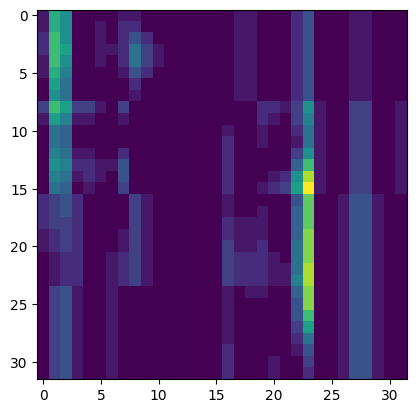

torch.Size([1, 1, 32, 32])


ValueError: too many values to unpack (expected 2)

In [17]:
test_spec = Image.open("Data/SpectrogramsA/pop/pop_spec53.jpg")
make_tensor = torchvision.transforms.ToTensor()
test_spec = transform(test_spec)
test_spec = torch.transpose(test_spec, 0, 2)

fig, axs = plt.subplots(1)
axs.imshow(test_spec)
plt.show()


test_spec = torch.transpose(test_spec, 0, 2)
test_spec = torch.unsqueeze(test_spec, 0)
# test_spec = torch.transpose(test_spec, 0, 1)

print(test_spec.shape)
test1, test2 = slice_images(test_spec)
test_spec1 = generator(test1)
test_spec2 = generator(test2)
test_spec = assemble_images(test_spec1, test_spec2)

test_spec = torch.squeeze(test_spec, 0)
test_spec = torch.transpose(test_spec, 0, 2)

print(test_spec.shape)
fig, axs = plt.subplots(1)
axs.imshow(test_spec.detach())
plt.show()



In [ ]:
rock_batch = next(iter(dataloader_B))
p = rock_batch[0]
res = generator(p)
#b1, b2 = slice_images(rock_batch)
# p1 = generator(b1)
# p2 = generator(b2)
# p = assemble_images(p1, p2)

plt.figure(figsize=(25,25))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Fake images")
plt.imshow(np.transpose(torchvision.utils.make_grid(res.to(device), padding=5, normalize=True).cpu(),(1,2,0)))



# plt.subplot()
# plt.axis("off")
# plt.title("Fake Images")
# plt.imshow(np.transpose(res.detach(),(1,2,0)))
# plt.show()

In [ ]:
# real_batch = next(iter(dataloader))
real_batch = next(iter(dataloader_A))

plt.figure(figsize=(25,25))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real images")
plt.imshow(np.transpose(torchvision.utils.make_grid(rock_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))


# plt.subplot(1,2,2)
# plt.axis("off")
# plt.title("Fake Images")
# plt.imshow(np.transpose(img_lists[-1],(1,2,0)))
# plt.show()

In [ ]:
print("1")